## A complex (multistep) reaction `A <-> C` derived from 2 coupled elementary reactions:   
## `A <-> B` (slow) and `B <-> C` (fast)  
A repeat of experiment `cascade_2_a`, with more DISSIMILAR elementary reactions.

In PART 1, a time evolution of [A], [B] and [C] is obtained by simulation   
In PART 2, the time functions generated in Part 1 are taken as a _starting point,_ to explore how to model the composite reaction `A <-> C`   

**Background**: please see experiment `cascade_2_a`  

LAST REVISED: June 23, 2024 (using v. 1.0 beta36)

In [1]:
import set_path      # Importing this module will add the project's home directory to sys.path

Added 'D:\Docs\- MY CODE\BioSimulations\life123-Win7' to sys.path


In [2]:
from experiments.get_notebook_info import get_notebook_basename

from life123 import UniformCompartment
from life123.visualization.plotly_helper import PlotlyHelper

# PART 1 - We'll generate the time evolution of [A] and [C] by simulating coupled elementary reactions of KNOWN rate constants...
## but pretend you don't see this section! (because we later assume that those time evolutions are just GIVEN to us)

In [3]:
# Instantiate the simulator and specify the chemicals
dynamics = UniformCompartment(names=["A", "B", "C"], preset="mid")

# Reaction A <-> B (much slower, and with a much smaller K)
dynamics.add_reaction(reactants="A", products="B",
                      forward_rate=8., reverse_rate=2.) 

# Reaction B <-> C (much faster, and with a much larger K)
dynamics.add_reaction(reactants="B", products="C",
                      forward_rate=80., reverse_rate=0.1)   # <===== THIS IS THE KEY DIFFERENCE FROM THE EARLIER EXPERIMENT `cascade_2_a`
                                   
dynamics.describe_reactions()

Number of reactions: 2 (at temp. 25 C)
0: A <-> B  (kF = 8 / kR = 2 / delta_G = -3,436.6 / K = 4) | 1st order in all reactants & products
1: B <-> C  (kF = 80 / kR = 0.1 / delta_G = -16,571 / K = 800) | 1st order in all reactants & products
Set of chemicals involved in the above reactions: {'C', 'A', 'B'}


### Run the simulation

In [4]:
dynamics.set_conc({"A": 50.}, snapshot=True)  # Set the initial concentrations of all the chemicals, in their index order
dynamics.describe_state()

SYSTEM STATE at Time t = 0:
3 species:
  Species 0 (A). Conc: 50.0
  Species 1 (B). Conc: 0.0
  Species 2 (C). Conc: 0.0
Set of chemicals involved in reactions: {'C', 'A', 'B'}


In [5]:
dynamics.single_compartment_react(initial_step=0.01, duration=0.8,
                                  snapshots={"initial_caption": "1st reaction step",
                                             "final_caption": "last reaction step"},
                                  variable_steps=True)

Some steps were backtracked and re-done, to prevent negative concentrations or excessively large concentration changes
102 total step(s) taken
Number of step re-do's because of negative concentrations: 0
Number of step re-do's because of elective soft aborts: 1
Norm usage: {'norm_A': 15, 'norm_B': 16, 'norm_C': 14, 'norm_D': 14}


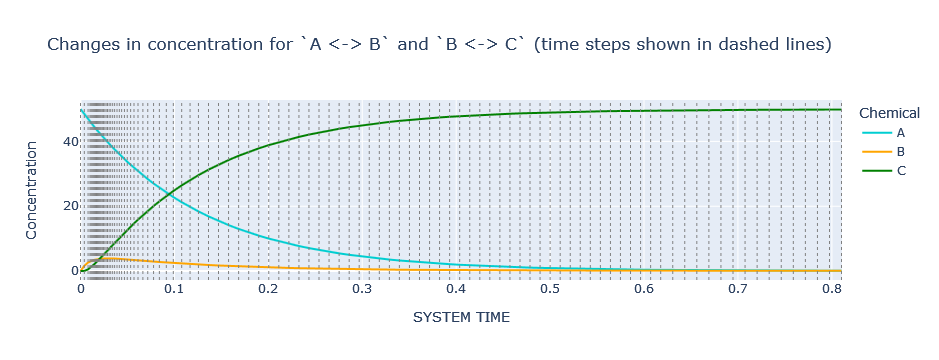

In [6]:
dynamics.plot_history(colors=['darkturquoise', 'orange', 'green'], show_intervals=True)

In [7]:
dynamics.is_in_equilibrium()

0: A <-> B
Final concentrations: [A] = 0.08481 ; [B] = 0.06976
1. Ratio of reactant/product concentrations, adjusted for reaction orders: 0.822525
    Formula used:  [B] / [A]
2. Ratio of forward/reverse reaction rates: 4
Discrepancy between the two values: 79.44 %
Reaction is NOT in equilibrium (not within 1% tolerance)

1: B <-> C
Final concentrations: [B] = 0.06976 ; [C] = 49.85
1. Ratio of reactant/product concentrations, adjusted for reaction orders: 714.525
    Formula used:  [C] / [B]
2. Ratio of forward/reverse reaction rates: 800
Discrepancy between the two values: 10.68 %
Reaction is NOT in equilibrium (not within 1% tolerance)



{False: [0, 1]}

We didn't quite advance to equilibrium this time.  A separate run (not shown) displayed far-better values if we had progressed the simulation just a little more in time. 

# PART 2 - This is the starting point of fitting the data from part 1.  
### We're given the data of the time evolution of `A` and `C`, and we want to try to model the complex reaction `A <-> C`

Let's start by taking stock of the actual data (saved during the simulation of part 1):

In [8]:
df = dynamics.get_history(columns=["SYSTEM TIME", "A", "C", "caption"])    # We're NOT given the intermediary B
df

SYSTEM TIME          A          C             caption
0       0.000000  50.000000   0.000000   Initialized state
1       0.004000  48.400000   0.000000   1st reaction step
2       0.008000  46.864000   0.512000                    
3       0.010000  46.124672   0.931738                    
4       0.011000  45.761562   1.167132                    
..           ...        ...        ...                 ...
98      0.758938   0.121082  49.805302                    
99      0.771777   0.110536  49.816969                    
100     0.784616   0.101044  49.827470                    
101     0.797455   0.092501  49.836921                    
102     0.810294   0.084812  49.845428  last reaction step

[103 rows x 4 columns]

## Column B is NOT given to us.  For example, `B` might be an intermediary we can't measure.  
#### Only [A] and [C] are given to us, on some variably-spaced time grid

#### Let's extract some columns, as Numpy arrays:

In [9]:
t_arr = df["SYSTEM TIME"].to_numpy()   # The independent variable : Time

In [10]:
A_conc = df["A"].to_numpy()

In [11]:
C_conc = df["C"].to_numpy()

#### If the composite reaction `A <-> C` could be modeled as an elementary reaction, we'd expect the rate of change of [C] to be proportional to [A]  
Let's see what happens if we try to do such a linear fit!

Total REACTANT + PRODUCT has a median of 49.19, 
    with standard deviation 1.519 (ideally should be zero)
The sum of the time derivatives of reactant and product 
    has a median of 1.073 (ideally should be zero)
Least square fit: Y = 15.82 + 6.197 X
    where X is the array [A] and Y is the time gradient of C

-> ESTIMATED RATE CONSTANTS: kF = 6.519 , kR = -0.3215


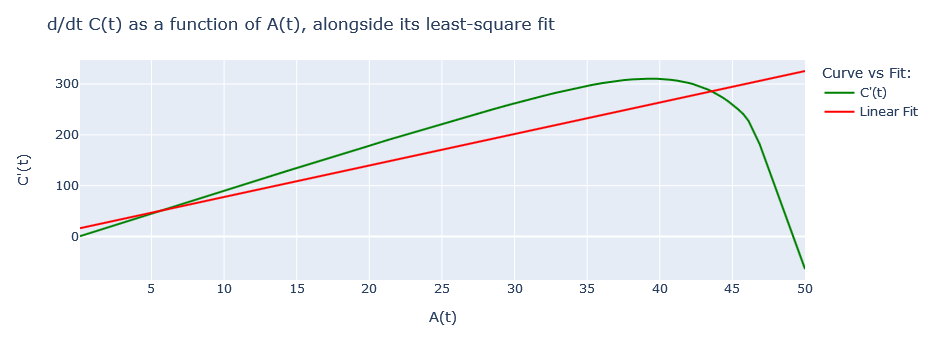

In [12]:
dynamics.estimate_rate_constants(t=t_arr, reactant_conc=A_conc, product_conc=C_conc, reactant_name="A", product_name="C")

### The least-square fit is awful : the complex reaction `A <-> C` doesn't seem to be amenable to being modeled as a simple reaction with some suitable rate constants

### But it looks like we'll do much better if splitting into 2 portions, one where A(t) ranges from 0 to about 40, and one from about 40 to 50   
Indeed, revisiting the early portion of the time plot from Part 1, one can see an inflection in the [C] green curve roughly around time t=0.028, which is when [A] is around 40 (turquoise).  That's around the peak of the mystery intermediate B (orange).

We'll pick time **t=0.028** as the divider between the 2 domains of the `A <-> C` time evolution that we want to model. 

Note that this is a much smaller time than we saw in experiment `cascade_2_a`

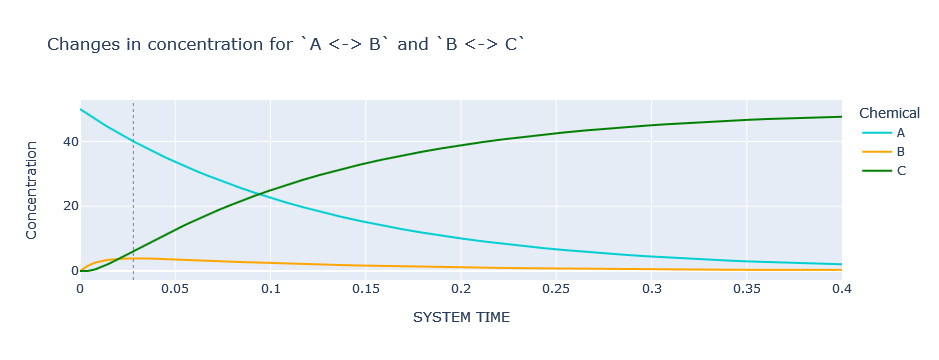

In [13]:
dynamics.plot_history(colors=['darkturquoise', 'orange', 'green'], xrange=[0, 0.4], 
                      vertical_lines=[0.028])

#### Let's locate where the t = 0.028 point occurs in the data

In [14]:
dynamics.get_history(t=0.028)

search_value  SYSTEM TIME          A       B         C caption
19         0.028      0.02728  40.260772  3.8859  5.853329

### Let's split the `A_conc` and `C_conc` arrays we extracted earlier (with the entire time evolution of, respectively, [A] and [C]) into two parts:  
1) points numbered 0-19  
2) points 19-end

In [15]:
A_conc_early = A_conc[:20]
A_conc_late = A_conc[20:]

C_conc_early = C_conc[:20]
C_conc_late = C_conc[20:]

t_arr_early = t_arr[:20]
t_arr_late = t_arr[20:]

### I. Let's start with the EARLY region, when t < 0.028

Total REACTANT + PRODUCT has a median of 46.44, 
    with standard deviation 0.9145 (ideally should be zero)
The sum of the time derivatives of reactant and product 
    has a median of -62.86 (ideally should be zero)
Least square fit: Y = 1,664 + -32.13 X
    where X is the array [A] and Y is the time gradient of C

-> ESTIMATED RATE CONSTANTS: kF = 3.71 , kR = -35.84


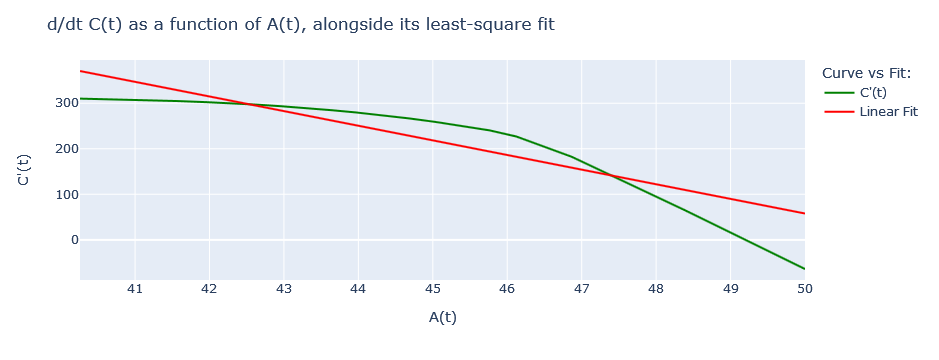

In [16]:
dynamics.estimate_rate_constants(t=t_arr_early, reactant_conc=A_conc_early, product_conc=C_conc_early, 
                                 reactant_name="A", product_name="C")

Just as we saw in experiment `cascade_2_a`, trying to fit an elementary reaction to that region leads to a **negative** reverse rate constant!   
This time, we won't discuss this part any further.

### II. And now let's consider the LATE region, when t > 0.028

Total REACTANT + PRODUCT has a median of 49.59, 
    with standard deviation 1.353 (ideally should be zero)
The sum of the time derivatives of reactant and product 
    has a median of 2.347 (ideally should be zero)
Least square fit: Y = 2.263 + 8.377 X
    where X is the array [A] and Y is the time gradient of C

-> ESTIMATED RATE CONSTANTS: kF = 8.422 , kR = -0.04564


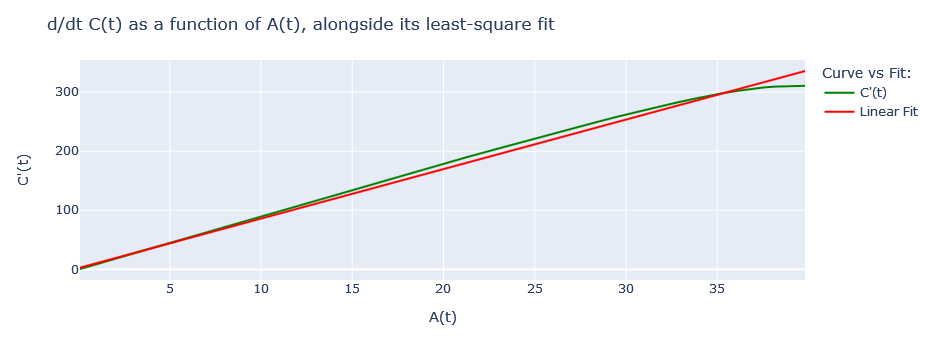

In [17]:
dynamics.estimate_rate_constants(t=t_arr_late, reactant_conc=A_conc_late, product_conc=C_conc_late, 
                                 reactant_name="A", product_name="C")

This time we have an adequate linear fit AND meaningful rate constants : kF of about 8 and kR of about 0.  Do those numbers sound familiar?  A definite resemblance to the kF=8, kR=2 of the SLOWER elementary reaction `A <-> B`!  

#### The slower `A <-> B` reaction dominates the kinetics from about t=0.028 on    

Let's see the graph again:

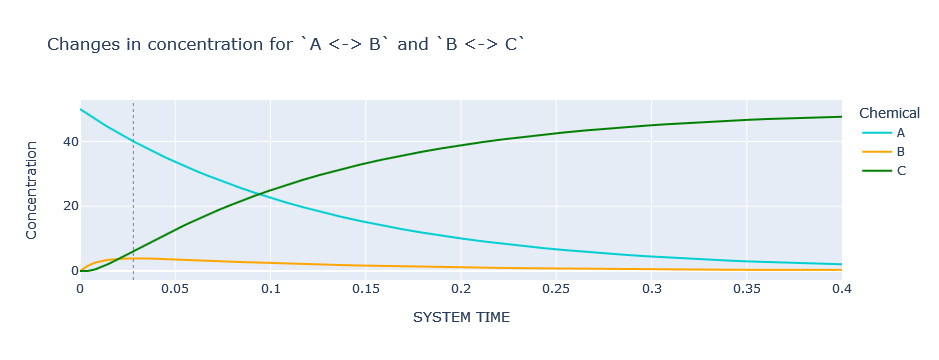

In [18]:
dynamics.plot_history(colors=['darkturquoise', 'orange', 'green'], xrange=[0, 0.4], 
                      vertical_lines=[0.028])

Just as we concluded in experiment `cascade_2_a`, the earlier part of the complex (compound) reaction `A <-> C` cannot be modeled by an elementary reaction, while the later part can indeed be modeled by a 1st order elementary reaction, with kinetics similar to the slower `A <-> B` reaction.  This time, with a greater disparity between the two elementary reaction, the transition happens much sooner.

### While it's a well-known Chemistry notion that the slower reaction is the rate-determining step in a chain, we saw in this experiment, and in the previous one, that the complex reaction could be roughly modeled with the rate constants of the slower reaction only after some time - especially if the 2 elementary reactions are relatively similar (as in the previous experiment).  

If we were interested in early transients (for example, if diffusion quickly intervened), we couldn't use that model.

#### In the continuation experiment, `cascade_2_c`, we explore the scenario where the 2 elementary reactions are reversed in their relative speeds